# Iterative GP

In [2]:
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
import emcee
import corner
import pyDOE
import scipy

# Theory

Most of the other notes assume that creating a GP has a few steps:
* Choose training points
* Evaluate the function we are trying to emulate at those points
* Do whatever it is we wanted to do (e.g. posterior inference) using the trained GP.

However, we often don't know where we need to get good training data before we have any. So, this process requires us to collect a large number of samples, many of which will be in really poor positions, to get enough samples in good locations.
An alternative is to first roughly approximate the function with a few samples. Then get more samples in the regions of interest (regions that have a high probability of being high probability). And repeat.

See:
* https://arxiv.org/pdf/1812.04631.pdf
* https://en.wikipedia.org/wiki/Bayesian_optimization
* https://arxiv.org/abs/1807.02811

# Exampe

Let's say that we have some observations $y = f(x)$ where we don't know $f$. However, we think that we know some model $m(x, \theta)$ that is a good approximation of $f$. We now want to find the parameters $\theta$ for the model that match the observed $y$.

In summary we have,
* **observations**: the true values in bins of x that we obtained somehow 
* **model**: a function that relates $x \rightarrow y$ with some parameters $\theta$
* **model input**: $\theta$, the parameters to our model
* **model output**: the values of the model for the given input. Returns something that can be compared to observations.

In [104]:
theta_true = np.array([0.5, 1, -2, 3])
theta_prior_range = theta[:,np.newaxis] + np.array([-0.1, 0.1])


x_range = np.array([-3, 3])
obs_std = 0.1
train_samples = 5

m = lambda theta, x: np.dot(theta, np.vstack((np.power(x, 3), np.power(x, 2), np.power(x, 1), np.power(x, 0))))
x = np.linspace(x_range[0], x_range[1], num=100)
observations = m(theta, x) + np.random.normal(0, obs_std, size=len(x))

We want to find the theta that creates this plot


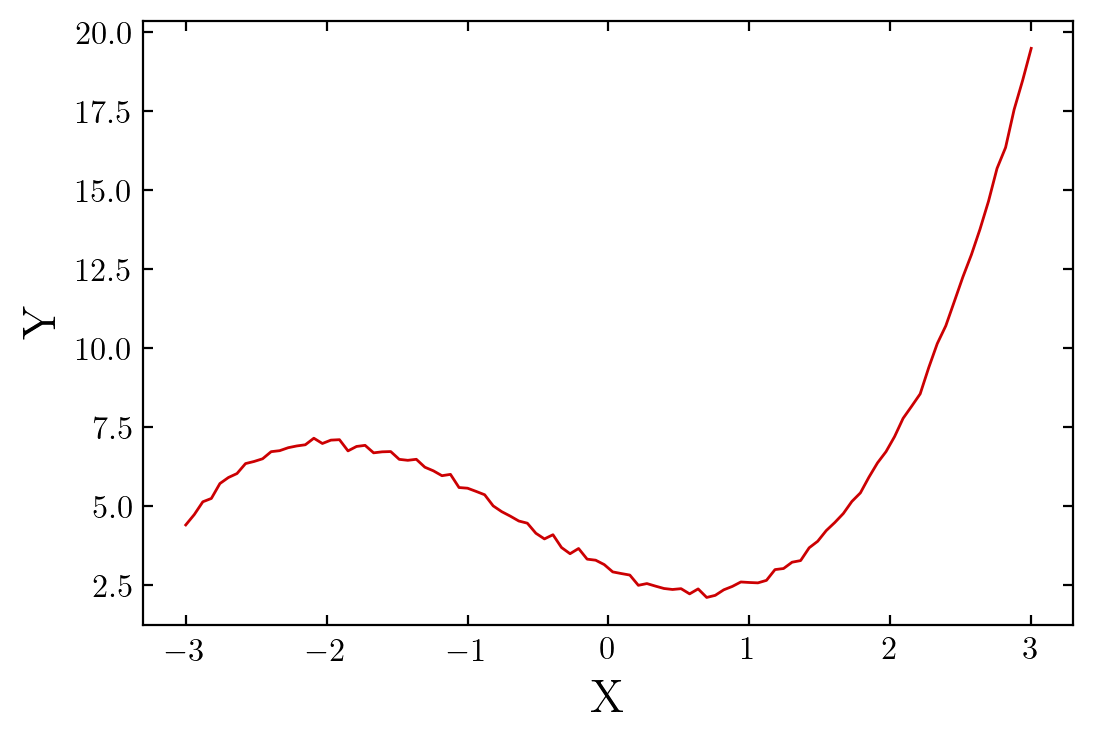

In [5]:
_, ax = plt.subplots()
ax.plot(x, observations)
ax.set(xlabel="X", ylabel="Y")
print("We want to find the theta that creates this plot")

In [275]:
def mcmc_log_likelihood(theta, x, observations, obs_std):
    predictions = m(theta, x)
    return log_likelihood(predictions, theta, observations, obs_std)
    
def gp_log_likelihood(theta, gp_m, observations, obs_std):
    predictions, errors = gp_m.predict(theta[np.newaxis,:])
    predictions = predictions[0]
    errors = errors[0][0] # note that this is variance
    return log_likelihood(predictions, theta, observations, np.sqrt(obs_std**2 + errors)) 

# GP diverge at the edges. So we exclude those regions when we check the uncertainty
tighter_theta_prior = theta_prior_range + (theta_prior_range[:,1] - theta_prior_range[:,0])[:,np.newaxis] * 0.05 * np.array([1, -1])
def gp_log_likelihood_unc(theta, gp_m, observations, obs_std):
    predictions, errors = gp_m.predict(theta[np.newaxis,:])
    predictions = predictions[0]
    errors = errors[0][0]
    
    # see equation 2.3 in https://arxiv.org/pdf/1812.04631.pdf
    # I'm still not really sure why, or comfortable that I am doing this perfectly...
    log_likelihood_unc = 0.5 * np.abs(
        log_likelihood(predictions + np.sqrt(errors), theta, observations, np.sqrt(obs_std**2 + errors)) -
        log_likelihood(predictions - np.sqrt(errors), theta, observations, np.sqrt(obs_std**2 + errors))
    )
    return np.dot(log_likelihood_unc, log_likelihood_unc) # Assuming a diagonal cov matrix

def within_prior(theta, prior):
    return np.all((theta > theta_prior_range[:,0]) & (theta < theta_prior_range[:,1]))
    
def log_likelihood(predictions, theta, observations, obs_std):
    prior_log_likelihood = 0 if within_prior(theta, theta_prior_range) else -1e10
    return -0.5 * np.sum(np.log(2 * np.pi * obs_std**2) + np.power(predictions - observations, 2) / obs_std**2, axis=len(theta.shape) - 1) + prior_log_likelihood

def run_mcmc(theta, log_likelihood_func, log_likelihood_args, plot=False):
    ndim, nwalkers = len(theta), 20
    r = np.random.random(size=(nwalkers, ndim))
    theta0 = theta_prior_range[:,0] * r + theta_prior_range[:,1] * (1-r)
    assert within_prior(theta0, theta_prior_range), theta0

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_func, args=log_likelihood_args)
    pos, prob, state = sampler.run_mcmc(theta0, 500)
    sampler.reset()
    sampler.run_mcmc(pos, 1000)
    if plot:
        return sampler, plot_chain(sampler)
    return sampler

def plot_chain(sampler):
    return corner.corner(
    sampler.flatchain,
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$", r"$\theta_4$"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    )

## Straight MCMC

If our model is fast to compute, then we can just run straight MCMC. This is beautifully simple and if you can do it **you should**. Don't get attracted by shiny things and try to use them because they come at some cost (complexity, approximation). End message to self.

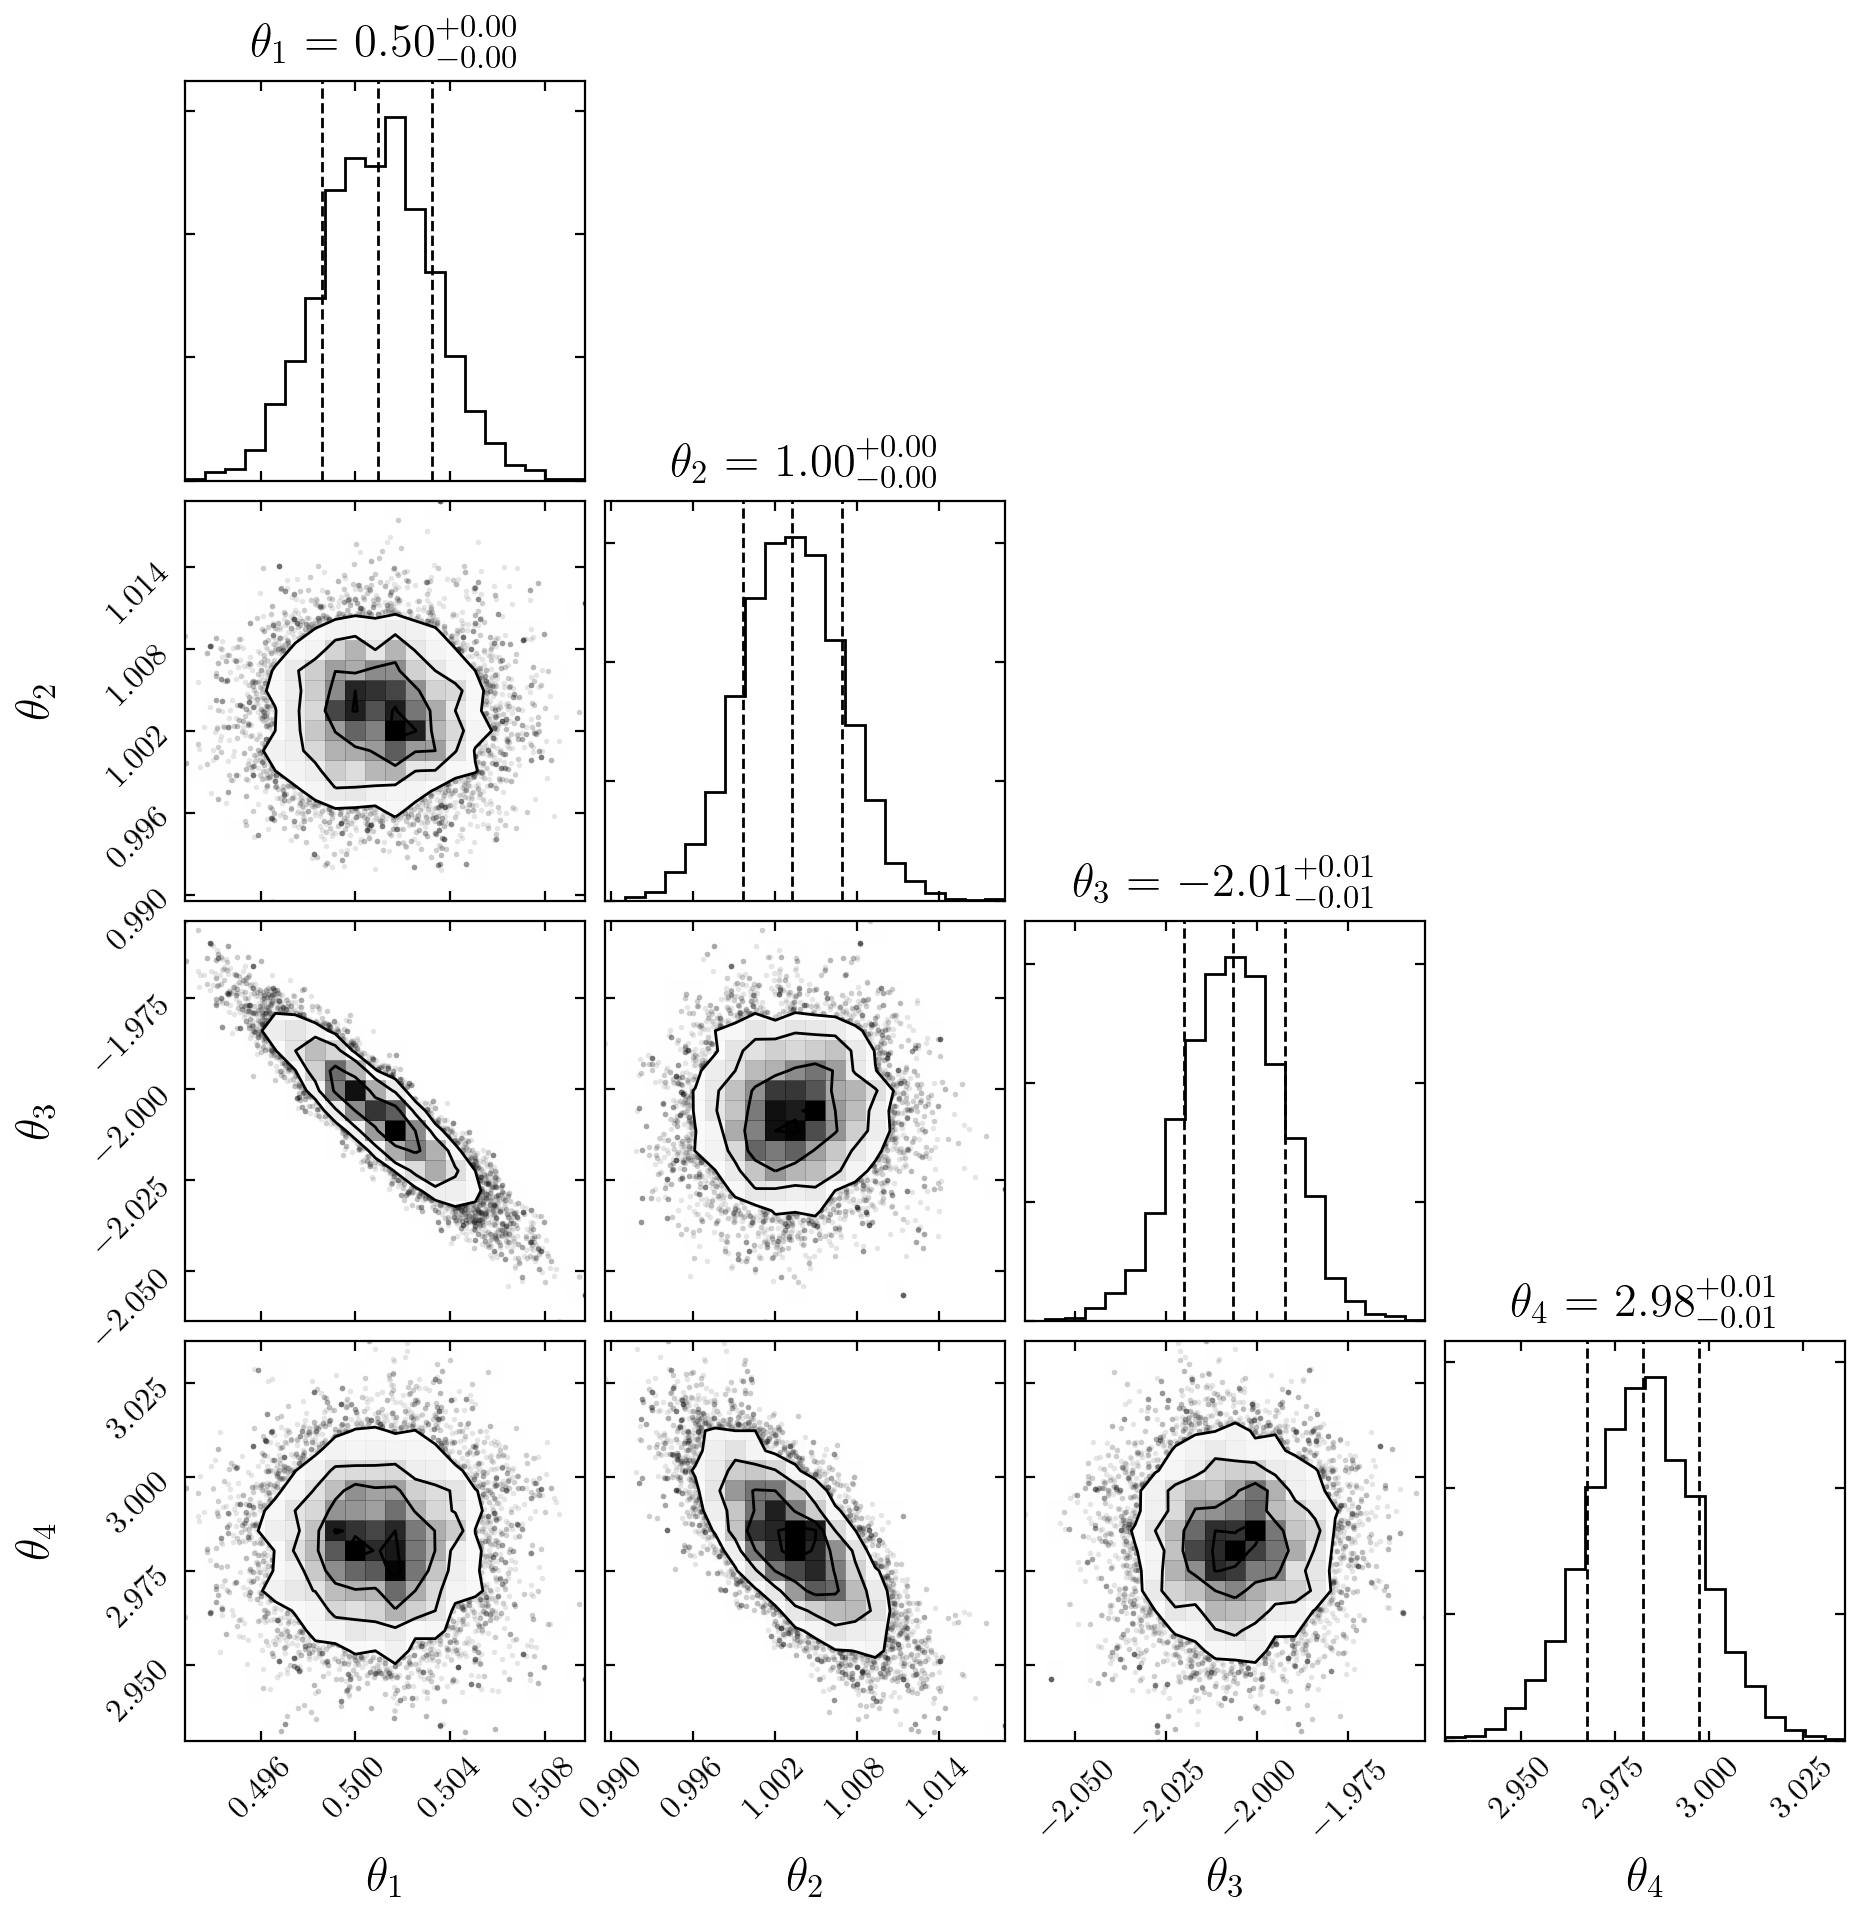

In [123]:
run_mcmc(theta, mcmc_log_likelihood, [x, observations, obs_std], True)

## GP

But sometimes MCMC isn't enough. Imagine the model were an N-body simulation. We can't run the ~$10^5$ iterations needed for MCMC to converge. In that case we need to do something cleverer.

Note that we are using the GP to predict the **function**, not the **log likelihood**.

[Text(0.5, 1.0, 'Training curves')]

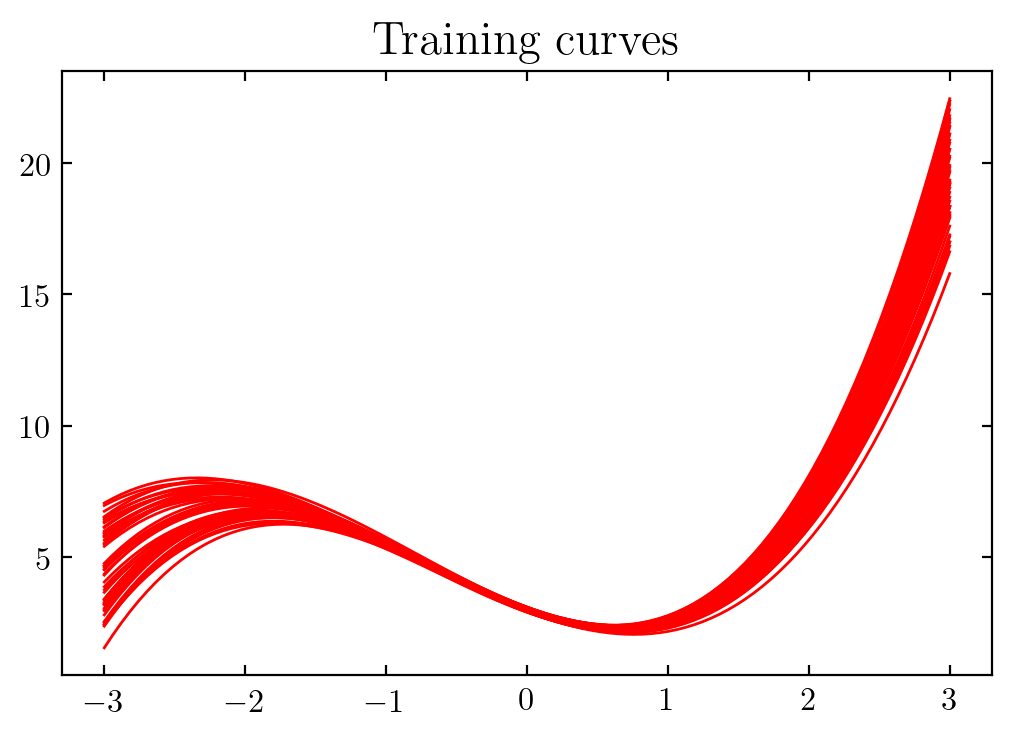

In [127]:
n_training = 50
training_theta = pyDOE.lhs(len(theta), n_training) * (theta_prior_range[:,1] - theta_prior_range[:,0]) + theta_prior_range[:,0]

training_y = m(training_theta, x)

_, ax = plt.subplots()
for i in range(len(training_y)):
    plt.plot(x, training_y[i], color="r")
ax.set(title="Training curves")

In [128]:
k = GPy.kern.RBF(len(theta), ARD=True)
gp_m = GPy.models.GPRegression(training_theta, training_y, k)
gp_m.optimize(messages=True)

 /home/christopher/.virtualenvs/learning/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/christopher/.virtualenvs/learning/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/christopher/.virtualenvs/learning/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


In [129]:
gp_log_liklihood(np.array([0.5, 1, 2, 3.1]), gp_m, observations, obs_std)

-10000245007.88267

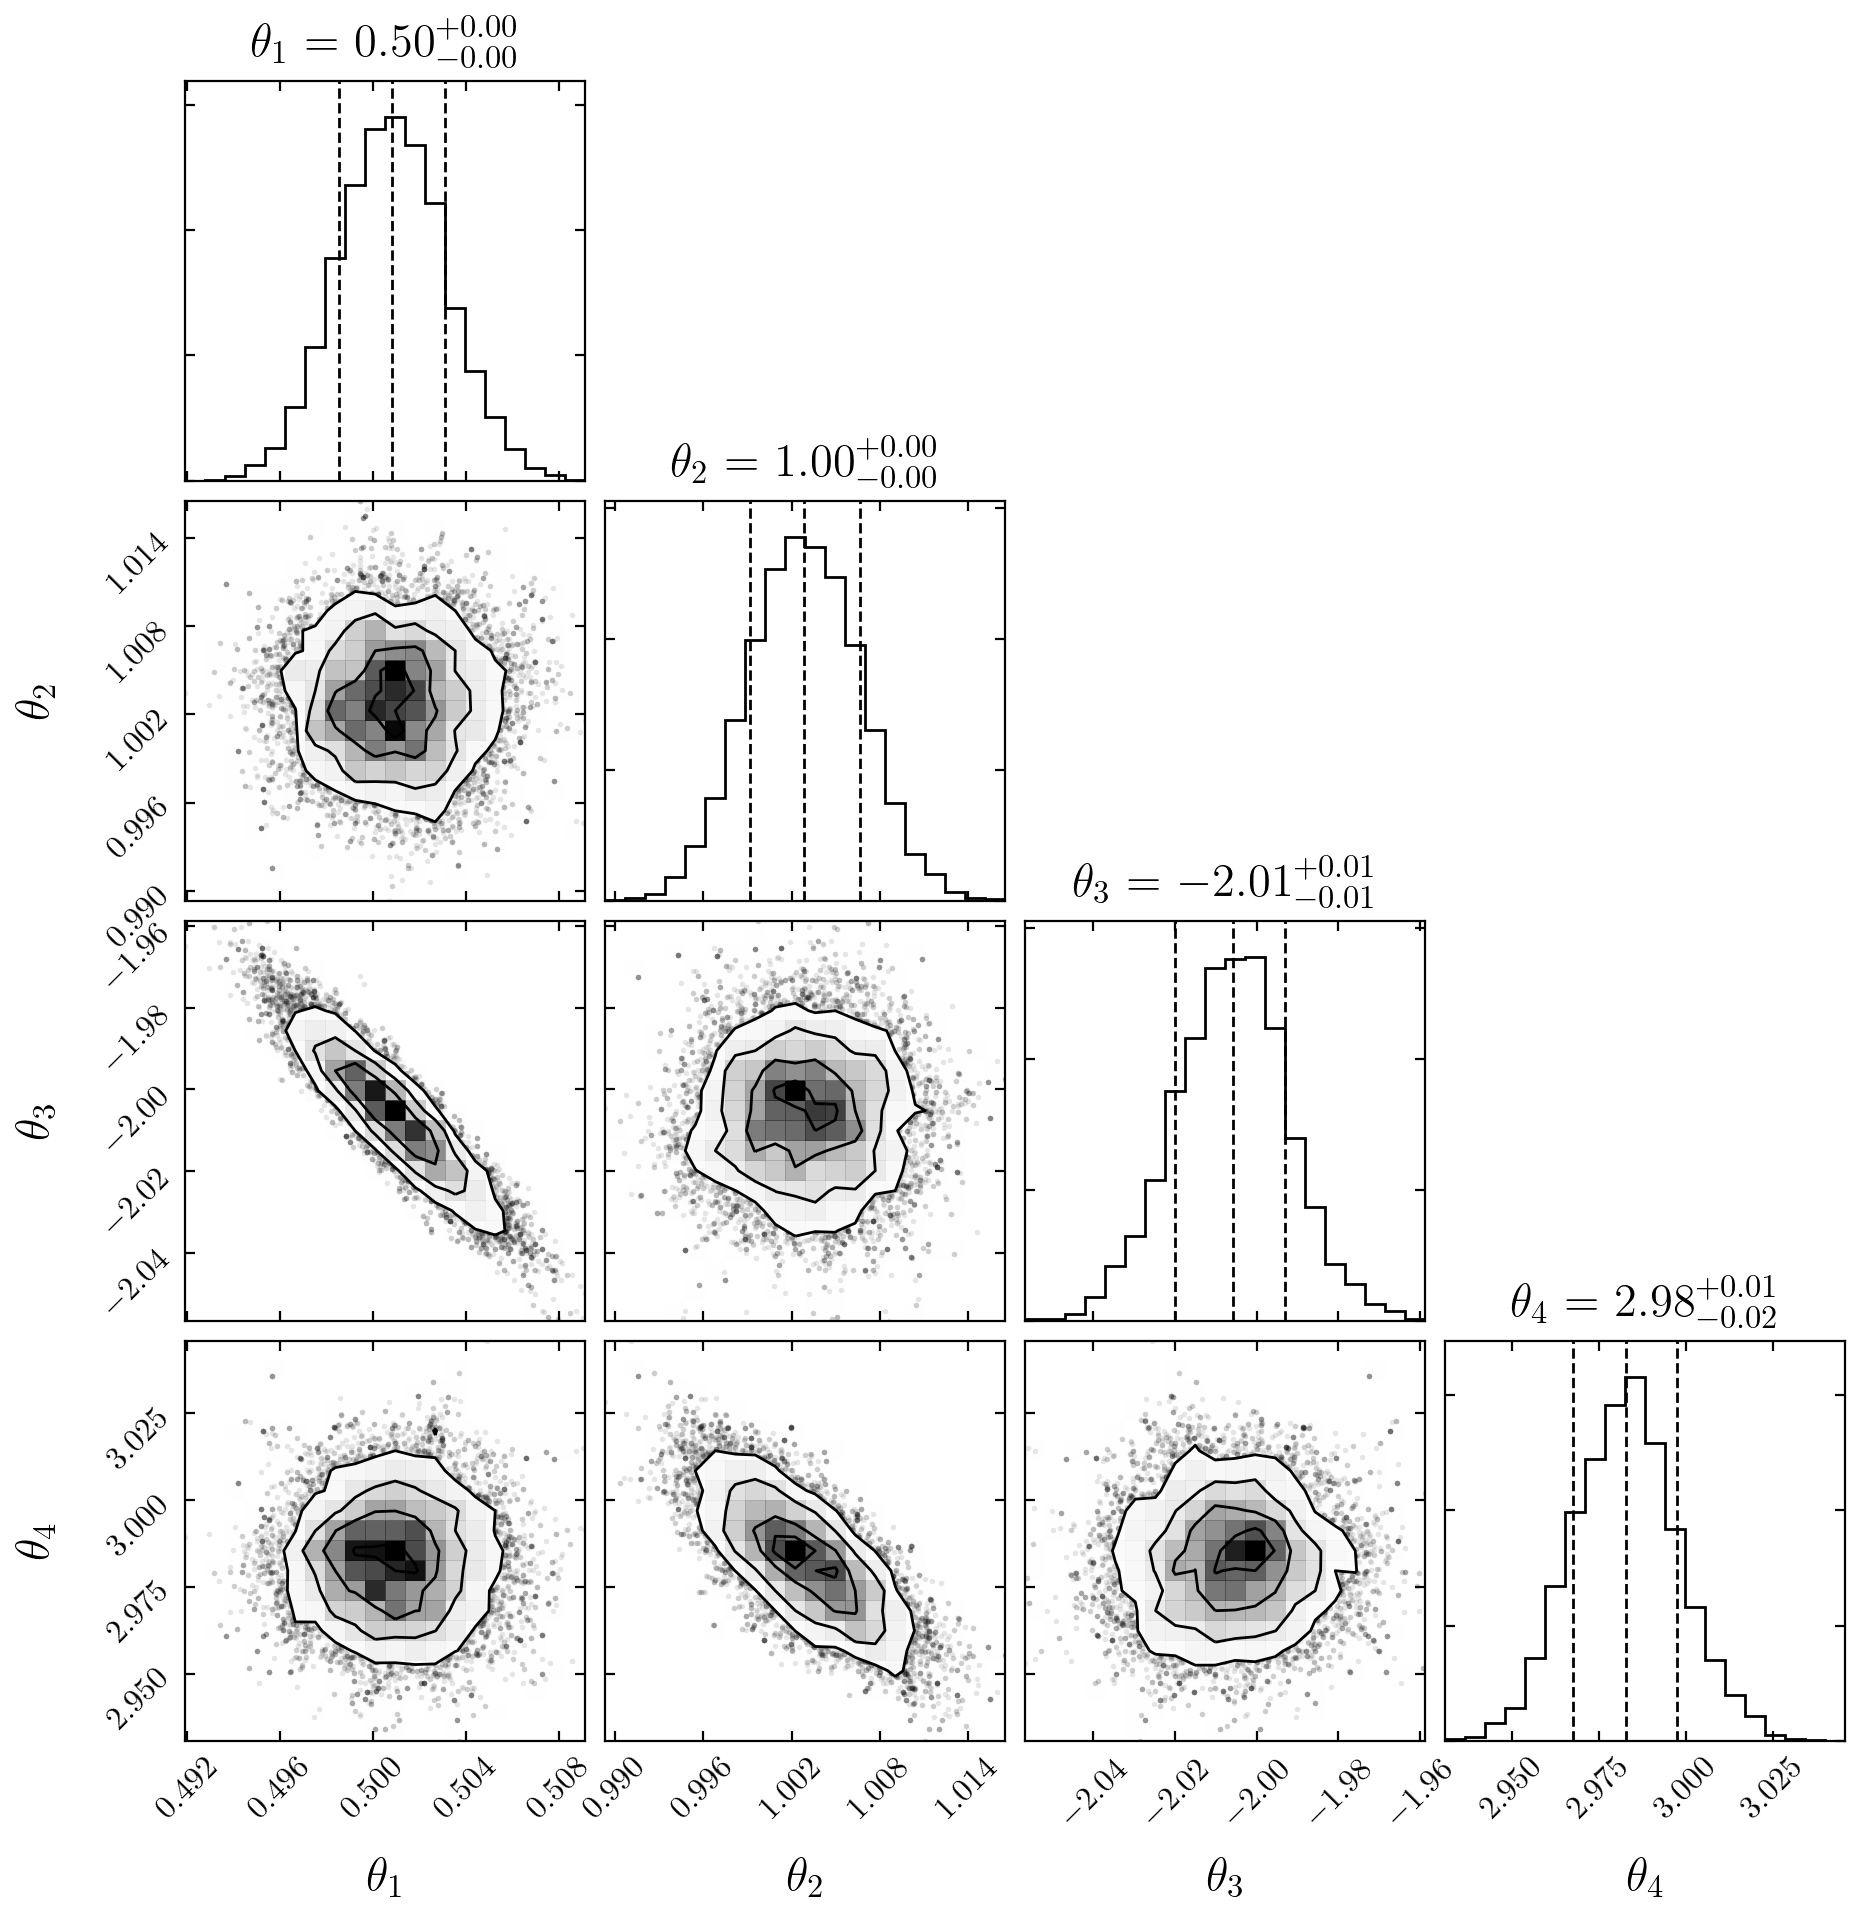

In [130]:
run_mcmc(theta, gp_log_liklihood, [gp_m, observations, obs_std], True)

## Iterative GP

Ok that was pretty cool. We got the same results with O(100) function evaluations! But, we probably could have done better. If we use the early function evaluations to pick the later locations more intelligently.

What does intelligently mean? We want to optimize 2 things - we should get data at thetas that:
* We think are regions of high probability
* We don't have well constrained at present

Doing just the first of these could lead us to just hammer away at near to the GP peak. Doing just the second might leave us exploring the edges of parameter range which we don't care about. This can be thought of as an explore-exploit problem. We exploit by choosing places that we think are good, but we explore by choosing places that we don't know well. The extent to which we prefer one or another is parameterized by a hyperparameter $\alpha$. We maximize:

$$
A(\theta) = L(\theta) + \alpha \sigma(\theta)
$$

where we call $A$ the acquisition function, $L$ is the likelihood, and $sigma$ is the uncertainty on the likelihood. If $\alpha = 1$ this therefore selects the location in parameter space where the upper 1 sigma on the likelihood is highest.

Note that our GP predicts and gives uncertainties on the function not the likelihood.

In [224]:
# Option 1, just get another data point at where the GP *thinks* the maximum is
r = np.random.random()
res = scipy.optimize.minimize(
    lambda theta: -gp_log_likelihood(theta, gp_m, observations, obs_std),
    theta_prior_range[:,0]*r + theta_prior_range[:,1]*(1-r), # Just start somewhere in the priors
    bounds=theta_prior_range,
)
assert res.success
print(f"GP max likelihood at {res.x}")


# Option 2, just get another data point where the GP is uncertain
res = scipy.optimize.minimize(
    lambda theta: -gp_log_likelihood_unc(theta, gp_m, observations, obs_std),
    tighter_theta_prior[:,0]*r + tighter_theta_prior[:,1]*(1-r), # Just start somewhere in the priors
    bounds=tighter_theta_prior,
)
assert res.success
print(f"GP max uncertainty at {res.x}")

# Option 3, use some combination of these two
alpha = 0.01
res = scipy.optimize.minimize(
    lambda theta: -(gp_log_likelihood(theta, gp_m, observations, obs_std) + alpha * gp_log_likelihood_unc(theta, gp_m, observations, obs_std)),
    tighter_theta_prior[:,0]*r + tighter_theta_prior[:,1]*(1-r), # Just start somewhere in the priors
    bounds=tighter_theta_prior,
)
assert res.success
print(f"GP max combination with alpha = {alpha} at {res.x}")

GP max likelihood at [ 0.49698857  0.99136369 -1.9860879   3.02915399]
GP max uncertainty at [ 0.41  0.91 -1.91  2.91]
GP max combination with alpha = 0.01 at [ 0.5012116   1.01899756 -2.01540177  3.03179643]


In [298]:
# Initial training sample
n_training = 5
training_theta = pyDOE.lhs(len(theta), n_training) * (theta_prior_range[:,1] - theta_prior_range[:,0]) + theta_prior_range[:,0]

training_y = m(training_theta, x)

alpha = 0.5
k = GPy.kern.RBF(len(theta), ARD=True)

for i in range(10):
    # Build current GP
    gp_m = GPy.models.GPRegression(training_theta, training_y, k)
    gp_m.optimize()
    
    
    # Find next point based off current GP
    for i in range(10):    
        res = scipy.optimize.minimize(
            lambda theta: -(gp_log_likelihood(theta, gp_m, observations, obs_std) + alpha * gp_log_likelihood_unc(theta, gp_m, observations, obs_std)),
            tighter_theta_prior[:,0]*r + tighter_theta_prior[:,1]*(1-r), # Just start somewhere in the priors
            bounds=tighter_theta_prior,
        )
        if res.success:
            break
    else:
        print("Failed to optimize /shrug")
    
    # We want to add some random noise to this suggestion so we don't just hammer at the peak at late times
    # We want this noise to be scaled by the posterior. So take the 1 sigma of the marginalized posterior in each dimension.
    # Not sure how to do this so will just add ~0.01 for now
    new_x = res.x + np.random.normal(size=len(res.x)) * 0.01
    
    # Evaluate function at the new x and add to training data
    training_theta = np.append(training_theta, new_x[np.newaxis,:], axis=0)
    training_y = np.append(training_y, m(new_x, x)[np.newaxis,:], axis=0)
    
    # Switch to exploit over time
    alpha -= 0.02

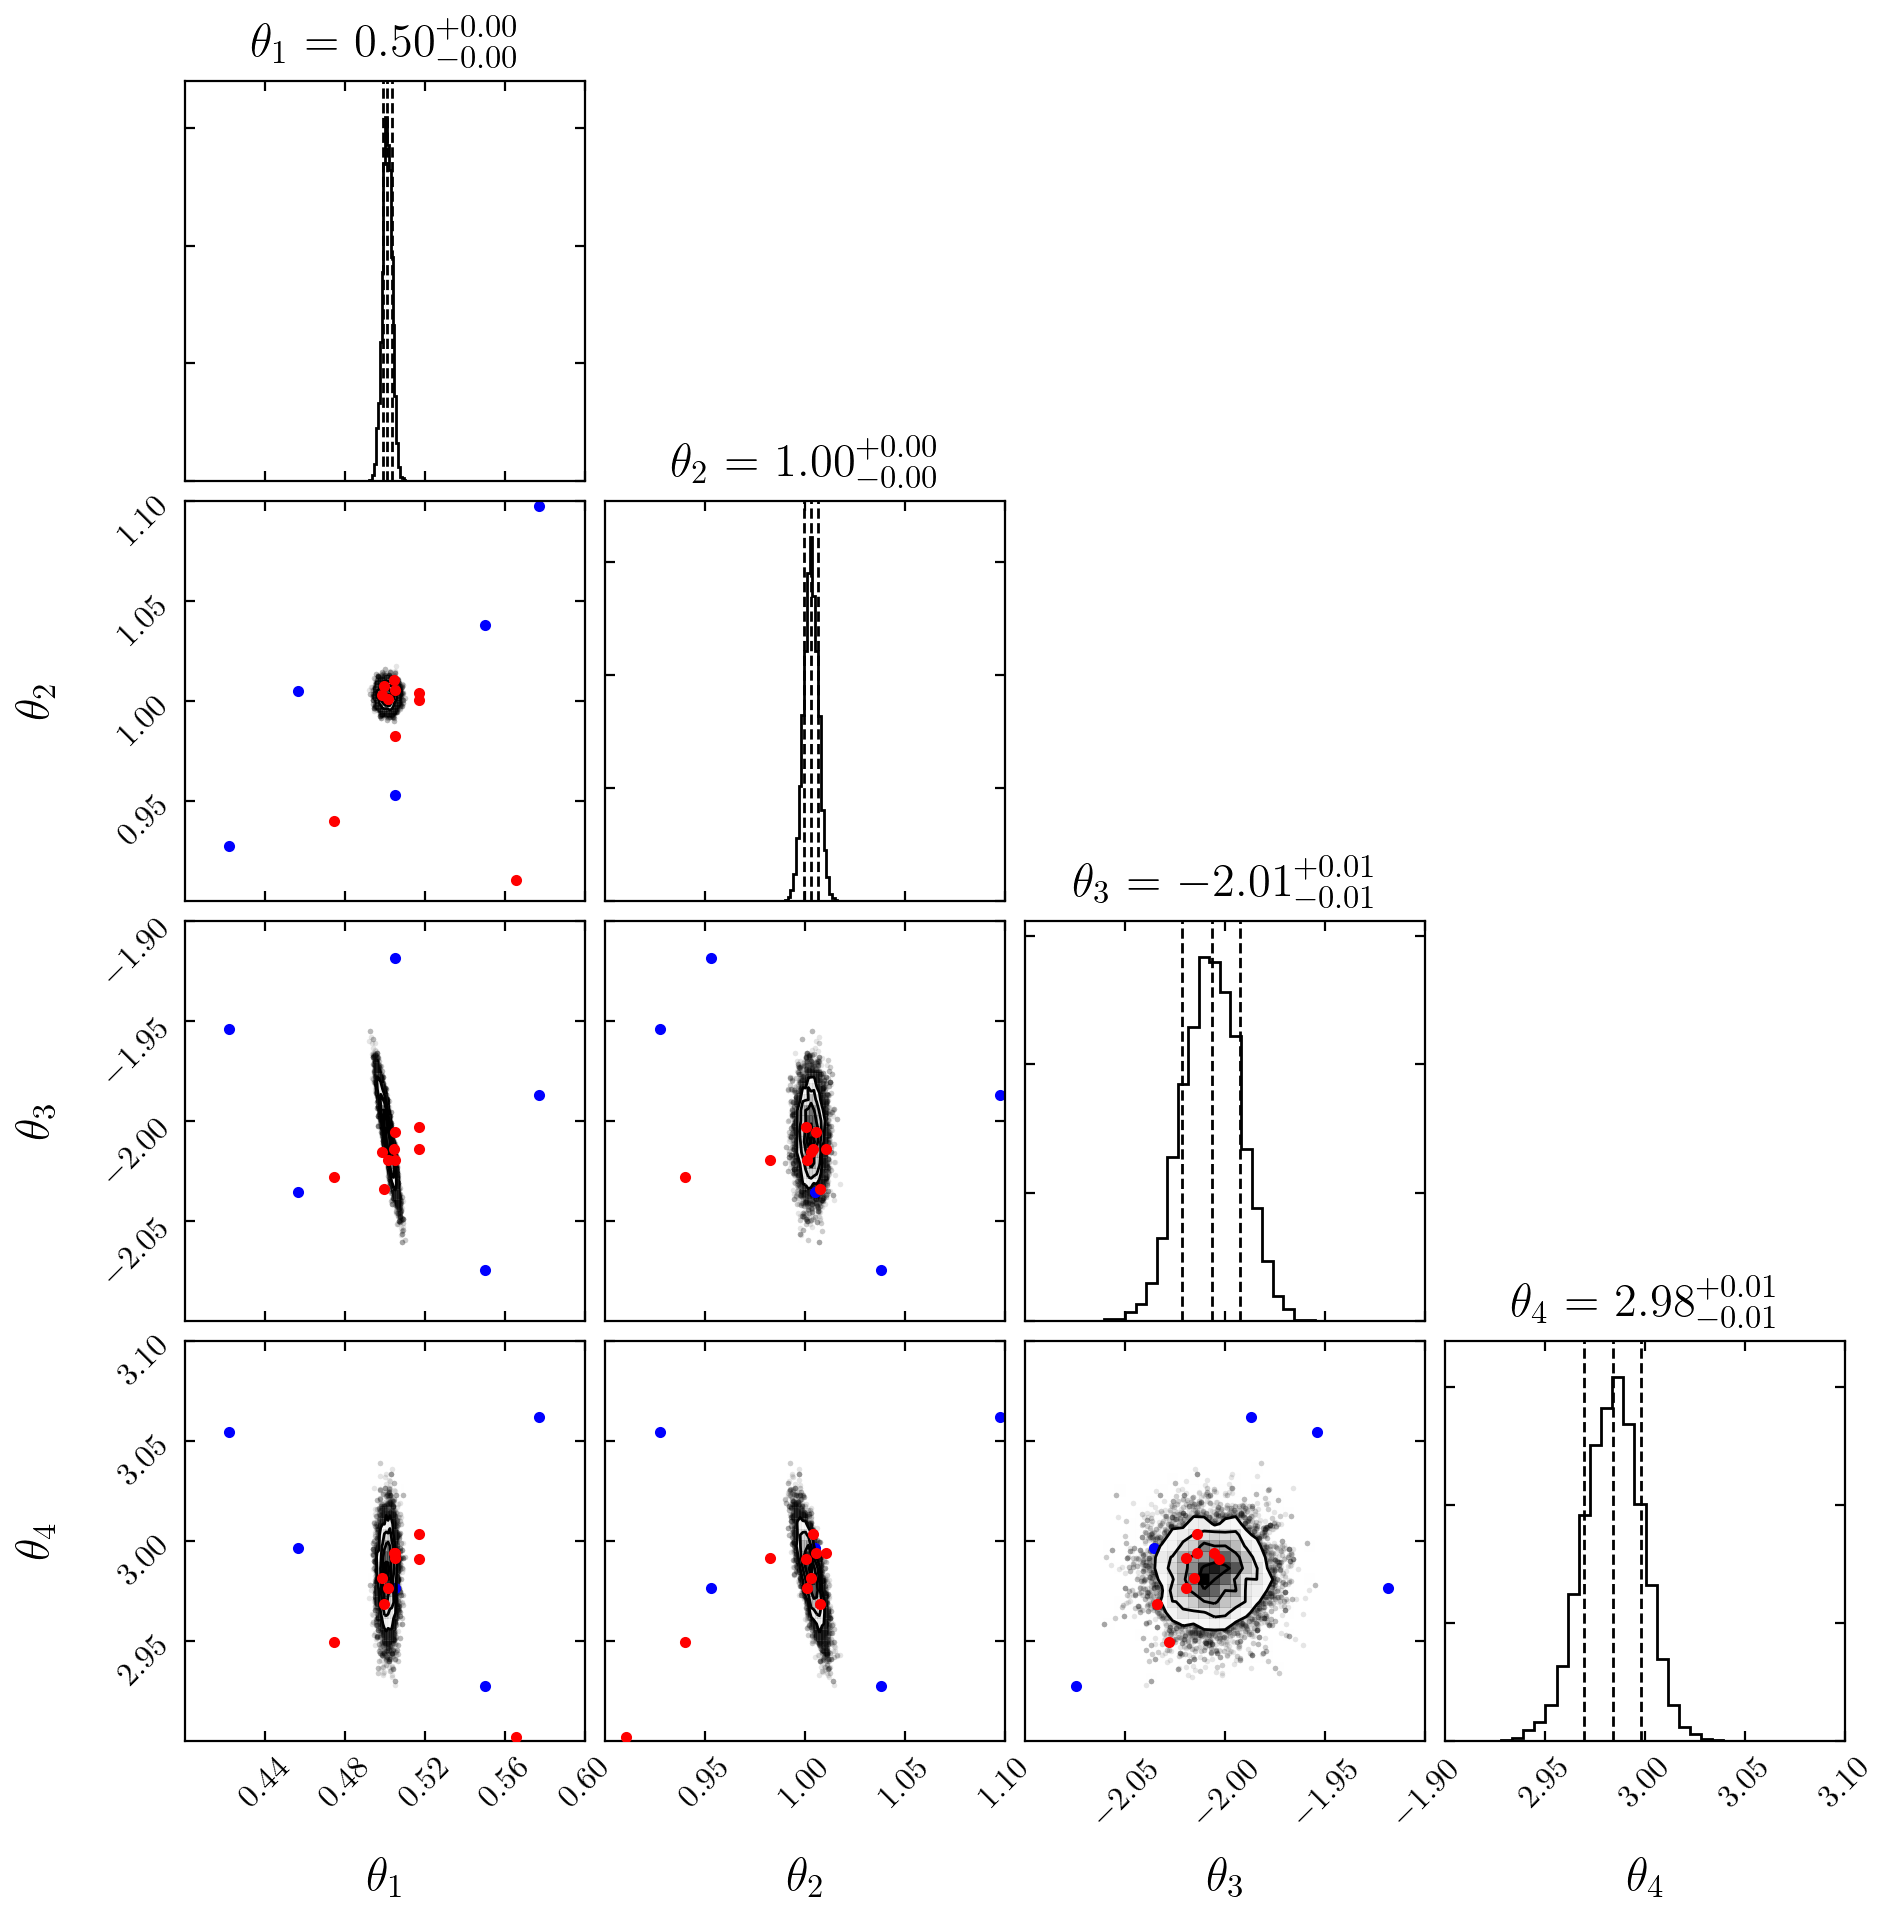

In [299]:
_, fig = run_mcmc(theta, gp_log_liklihood, [gp_m, observations, obs_std], True)

for row in range(len(theta)):
    for col in range(len(theta)):
        if row < col:
            continue
        elif row == col:
            ax = fig.axes[len(theta)*row + col]
            ax.set(xlim=theta_prior_range[row])
        else:
            ax = fig.axes[len(theta)*row + col]
            ax.scatter(training_theta[:,col][:n_training], training_theta[:,row][:n_training], color="blue")
            ax.scatter(training_theta[:,col][n_training:], training_theta[:,row][n_training:], color="red", zorder=5)
            ax.set(xlim=theta_prior_range[col], ylim=theta_prior_range[row])

See how we drill down into the region we care about!